# Python 08 — Introdução prática a Machine Learning com Python (Iris, scikit-learn e TensorFlow)

Este notebook é uma aula completa e prática cobrindo conceitos básicos de Machine Learning (ML) com Python, usando dois ecossistemas populares: **scikit-learn** (clássico/estatístico) e **TensorFlow/Keras** (redes neurais). Trabalharemos com o conjunto de dados clássico **Iris**.

Objetivos:
- Entender os conceitos fundamentais de ML supervisionado (features, rótulos, treino/teste, validação, métricas).
- Explorar o dataset Iris e realizar EDA (Análise Exploratória de Dados) básica.
- Treinar modelos com scikit-learn (Logistic Regression, SVC) usando boas práticas (Pipeline, padronização, validação cruzada, Grid Search).
- Salvar e carregar modelos treinados.
- Treinar uma rede neural simples com TensorFlow/Keras e comparar resultados.

Pré-requisitos (recomendado): Python 3.9+ e as bibliotecas `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`, `tensorflow`.

## 0) Instalação (opcional)
Se estiver rodando localmente e ainda não tiver as dependências, execute a célula abaixo. Ela usa o interpretador atual do Python para instalar os pacotes necessários.

Observação: a instalação do TensorFlow pode demorar e requer ambiente compatível. No Colab, geralmente não é necessário.

In [ ]:
# Instalação opcional de dependências (compatível com Colab e Jupyter)
# - Detecta Colab e instala pacotes necessários usando o mesmo interpretador do kernel.
# - Se já tiver tudo instalado, pode pular.

from __future__ import annotations
import sys, subprocess

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:  # noqa: BLE001
    IN_COLAB = False

PKGS = [
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'scikit-learn', 'joblib', 'tensorflow'
]

def pip_install(pkgs: list[str]) -> None:
    cmd = [sys.executable, '-m', 'pip', 'install', '-q', '-U', *pkgs]
    print('Instalando:', ' '.join(pkgs))
    subprocess.check_call(cmd)

if IN_COLAB:
    print('Ambiente Colab detectado. As dependências já devem estar disponíveis.')
    # pip_install(PKGS) # Descomente se precisar forçar a atualização
else:
    print('Instalação opcional — pule se o ambiente já tiver as dependências.')


Ambiente Colab detectado. As dependências já devem estar disponíveis.


## 1) Imports, Configurações e Verificação de Versões

- Importar bibliotecas e módulos.
- Definir sementes de aleatoriedade para reprodutibilidade.
- Verificar versões para diagnosticar problemas de ambiente.

In [ ]:
import sys
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configs de plot
#sns.set(theme="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

# Semente para reprodutibilidade
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Verificação de versões
print("Python:", sys.version.split()[0])
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)

Python: 3.12.11
Numpy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1
TensorFlow: 2.19.0


## 2) Conceitos básicos de ML supervisionado

- **Problema**: Classificar a espécie de uma flor (Iris) a partir de suas medidas (features).
- **Features (X)**: Comprimento/largura de sépalas e pétalas (4 variáveis numéricas).
- **Rótulo/Target (y)**: Espécie da flor (3 classes: setosa, versicolor, virginica).
- **Fluxo padrão**: Dividir dados em treino/teste, treinar o modelo nos dados de treino, validar e, finalmente, avaliar no conjunto de teste.
- **Métricas comuns**: Acurácia, precisão, revocação, F1-score.
- **Boas práticas**: Padronização dos dados, validação cruzada, manter o conjunto de teste intocado até a avaliação final.

## 3) Carregando o dataset Iris e Análise Exploratória Rápida (EDA)

Usaremos `sklearn.datasets.load_iris` e o converteremos para um `pandas.DataFrame` para facilitar a inspeção.

In [ ]:
iris = datasets.load_iris(as_frame=True)
df: pd.DataFrame = iris.frame.copy()
df.head()
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [ ]:
print("Colunas:", list(df.columns))
print("Classes (target_names):", list(iris.target_names))
print("Descrição resumida:\n", '\n'.join(iris.DESCR.split('\n')[0:5]))

# Mapear target numérico -> rótulo textual para visualizações
df["species"] = df["target"].map(dict(enumerate(iris.target_names)))
df.sample(5, random_state=SEED)

Colunas: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
Classes (target_names): [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
Descrição resumida:
 .. _iris_dataset:

Iris plants dataset
--------------------



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
73,6.1,2.8,4.7,1.2,1,versicolor
18,5.7,3.8,1.7,0.3,0,setosa
118,7.7,2.6,6.9,2.3,2,virginica
78,6.0,2.9,4.5,1.5,1,versicolor
76,6.8,2.8,4.8,1.4,1,versicolor


### 3.1) Estatísticas e Balanceamento de Classes

Vamos verificar as estatísticas descritivas e se as classes estão balanceadas.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,NaN,NaN,NaN,5.843333,0.828066,4.3,5.1,5.8,6.4,7.9
sepal width (cm),150.0,NaN,NaN,NaN,3.057333,0.435866,2.0,2.8,3.0,3.3,4.4
petal length (cm),150.0,NaN,NaN,NaN,3.758,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,NaN,NaN,NaN,1.199333,0.762238,0.1,0.3,1.3,1.8,2.5
target,150.0,NaN,NaN,NaN,1.0,0.819232,0.0,0.0,1.0,2.0,2.0
species,150,3,setosa,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


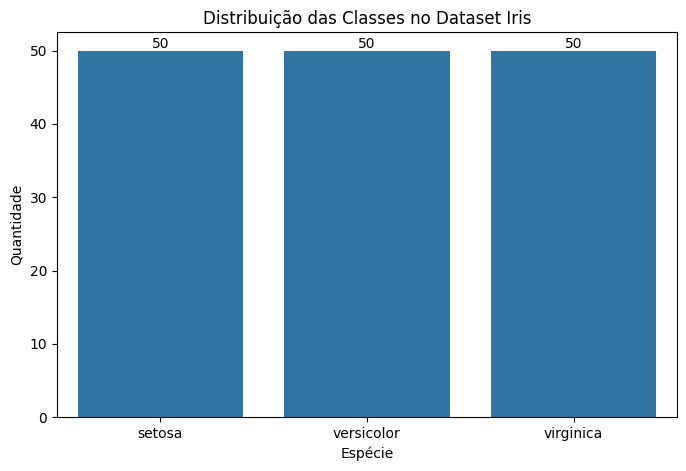

In [ ]:
# Estatísticas descritivas
display(df.describe(include="all").T)

# Distribuição de classes
plt.title("Distribuição das Classes no Dataset Iris")
ax = sns.countplot(data=df, x="species", order=sorted(df.species.unique()))
ax.bar_label(ax.containers[0])
plt.xlabel("Espécie")
plt.ylabel("Quantidade")
plt.show()

### 3.2) Relações entre variáveis

Um `pairplot` ajuda a visualizar a separabilidade entre as classes (pode demorar um pouco).

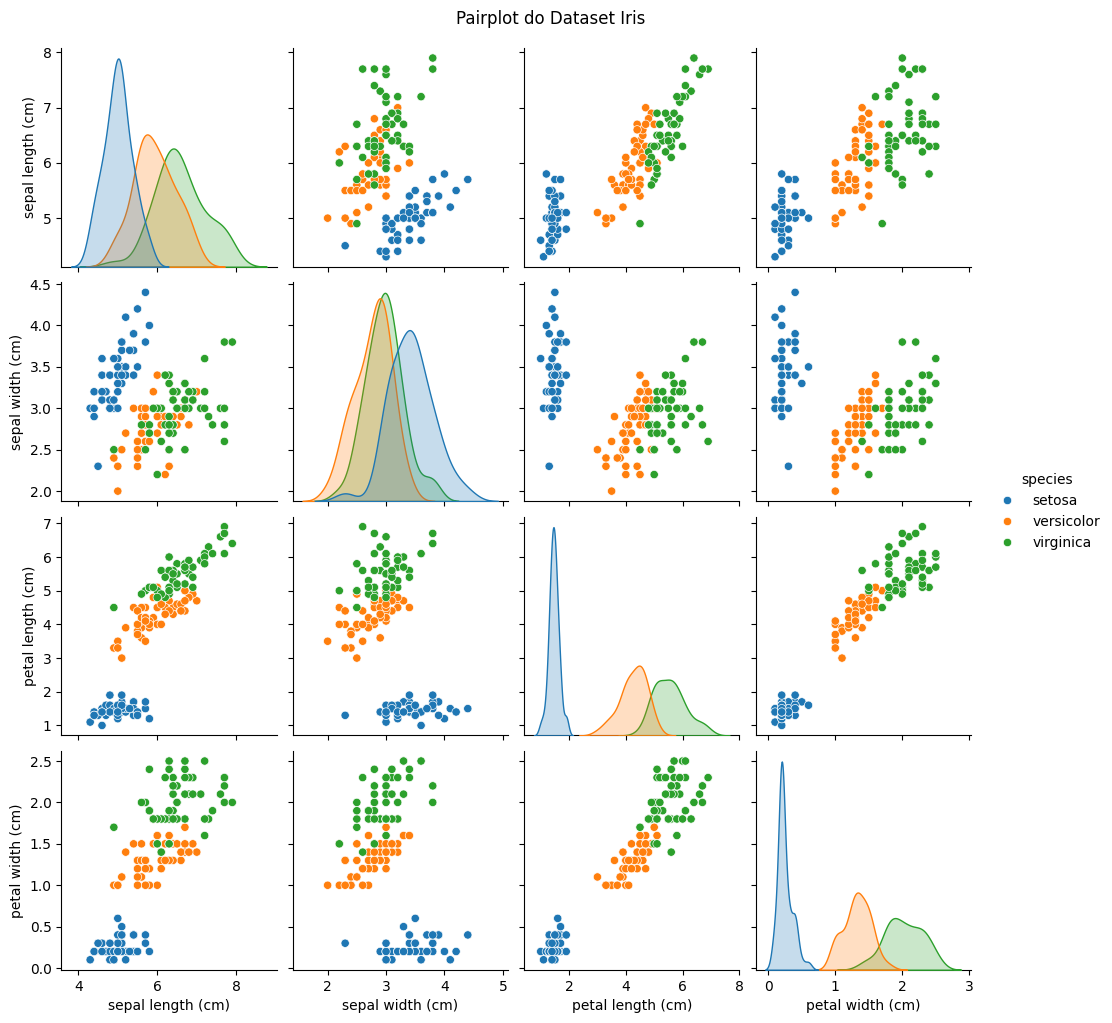

In [ ]:
sns.pairplot(df, vars=iris.feature_names, hue="species", diag_kind="kde")
plt.suptitle("Pairplot do Dataset Iris", y=1.02)
plt.show()

## 4) Treino/Teste, Pipeline e Primeiro Modelo (scikit-learn)

- Separação treino/teste com estratificação para manter a proporção das classes.
- Uso de um `Pipeline` simples com Regressão Logística.
- Métricas: acurácia, relatório de classificação e matriz de confusão.

Shape de X_train: (120, 4)
Shape de X_test: (30, 4)
Acurácia (LogisticRegression): 0.9333

Relatório de classificação:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



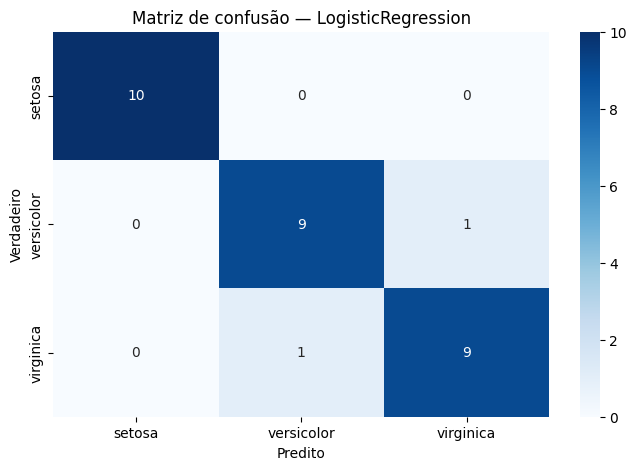

In [ ]:
# Features (X) e alvo (y)
X = df[iris.feature_names].to_numpy(dtype=np.float32)
y = df["target"].to_numpy(dtype=np.int64)

# Divisão em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")

# Criação e treino do pipeline com Regressão Logística
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=SEED)),
])
pipe_lr.fit(X_train, y_train)

# Previsão e avaliação
pred_lr = pipe_lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
print(f"Acurácia (LogisticRegression): {acc_lr:.4f}\n")

print("Relatório de classificação:\n", classification_report(y_test, pred_lr, target_names=iris.target_names))

# Matriz de confusão
cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Matriz de confusão — LogisticRegression")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

🌱 1. Separação de Features e Alvo
python
X = df[iris.feature_names].to_numpy(dtype=np.float32)
y = df["target"].to_numpy(dtype=np.int64)
X: matriz com as variáveis preditoras (comprimento/largura de pétalas e sépalas).

y: vetor com os rótulos das espécies (0 = setosa, 1 = versicolor, 2 = virginica).

Conversão para NumPy arrays com tipos específicos:

float32 para os dados numéricos.

int64 para os rótulos.

✂️ 2. Divisão em treino e teste
python
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
Divide os dados em:

80% para treino

20% para teste

stratify=y: garante que a proporção de cada classe seja mantida em ambas as divisões.

random_state=SEED: garante reprodutibilidade.

🔧 3. Criação do pipeline
python
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=SEED)),
])
Pipeline: encadeia etapas de pré-processamento e modelagem.

StandardScaler(): padroniza os dados (média 0, desvio padrão 1).

LogisticRegression(): modelo de classificação linear.

max_iter=1000: número máximo de iterações para convergência.

random_state=SEED: reprodutibilidade.

🧠 4. Treinamento do modelo
python
pipe_lr.fit(X_train, y_train)
Ajusta o pipeline aos dados de treino.

📊 5. Previsão e avaliação
python
pred_lr = pipe_lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
predict: gera previsões para os dados de teste.

accuracy_score: calcula a acurácia (proporção de acertos).

📋 6. Relatório de classificação
python
print(classification_report(y_test, pred_lr, target_names=iris.target_names))
Mostra métricas como:

Precisão (precision)

Revocação (recall)

F1-score

Para cada classe (espécie de flor).

🧮 7. Matriz de confusão
python
cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=iris.target_names, yticklabels=iris.target_names)
confusion_matrix: mostra os acertos e erros por classe.

sns.heatmap: visualiza a matriz como um mapa de calor.

Machine Learning com Python (resolução exercício proposto)

Passo 1: Importar Bibliotecas e Carregar Dados
• Usar bibliotecas como tensorflow, pandas e scikit-learn.
• Carregar o conjunto de dados Iris disponível no scikit-learn.

In [ ]:
# Importar bibliotecas
import tensorflow as tf
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
# Carregar conjunto de dados Iris
iris = load_iris()
X = iris.data
y = iris.target

Passo 2: Pré-processamento dos Dados
• Dividir o conjunto de dados em treinamento e teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

Normalizar os dados

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Passo 3: Construir o Modelo (Usar TensorFlow para construir um modelo de rede neural simples.)

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Dense(10, activation='relu',
input_shape=(X_train.shape[1],)),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

Passo 4: Treinar o Modelo
• Treinar o modelo com os dados de treinamento

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3591 - loss: 1.1103
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7367 - loss: 0.9923
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7913 - loss: 0.7415
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8322 - loss: 0.5235
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8508 - loss: 0.4128
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.3448
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8906 - loss: 0.2915
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8954 - loss: 0.2538
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.2238
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9573 - loss: 0.1980
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9482 - loss: 0.1765
Epoch 12/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Passo 5: Avaliar o Modelo
• Avaliar a precisão do modelo usando os dados de teste.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 1.0000 - loss: 0.0281
Loss: 0.028059901669621468
Accuracy: 1.0


Passo 6: Fazer Previsões
• Fazer previsões com o modelo treinado.

In [ ]:
predictions = model.predict(X_test)
print("Previsões:")
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Previsões:
[[1.5267212e-04 9.9550802e-01 4.3394198e-03]
 [9.9994999e-01 4.9908911e-05 1.1120385e-08]
 [3.0117873e-14 7.7504437e-06 9.9999219e-01]
 [1.9721467e-04 9.6104312e-01 3.8759559e-02]
 [1.4976279e-05 9.8166895e-01 1.8315982e-02]
 [9.9984765e-01 1.5236581e-04 1.4304326e-08]
 [3.3543857e-03 9.9578053e-01 8.6513994e-04]
 [4.0854506e-08 1.0685070e-02 9.8931497e-01]
 [3.1709266e-07 8.0595809e-01 1.9404158e-01]
 [2.6356085e-04 9.9913716e-01 5.9918215e-04]
 [7.7390077e-06 1.1778367e-01 8.8220859e-01]
 [9.9987769e-01 1.2235263e-04 1.7787816e-09]
 [9.9996096e-01 3.9001079e-05 1.6906617e-09]
 [9.9989563e-01 1.0428808e-04 2.1585849e-09]
 [9.9997300e-01 2.6999152e-05 9.3990362e-09]
 [1.1360931e-03 9.6301389e-01 3.5850018e-02]
 [7.6408728e-09 2.1487398e-03 9.9785125e-01]
 [9.7826145e-05 9.9956065e-01 3.4145135e-04]
 [3.2471083e-04 9.8949271e-01 1.0182539e-02]
 [1.6448015e-09 1.0360284e-03 9.9896383e-01]
 [9.9987745e-01 1.2269181e-04 7.4630968e-09]
 [2.74